In [49]:
import pyodbc
import pandas as pd
import config as cfg

In [50]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [51]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [52]:
cnxn = pyodbc.connect( 'DRIVER={ODBC Driver 13 for SQL Server};SERVER=' + cfg.mssql['server'] + ';DATABASE=' 
                      + cfg.mssql['database'] + ';UID=' + cfg.mssql['username'] + ';PWD=' + cfg.mssql['password'] )

In [53]:
query = "SELECT * FROM BankSampleView;"
data = pd.read_sql(query, cnxn, index_col='BankID')
data.head()

,UniqueNum,Name,Address1,Address2,City,State,Zip,Deposit,Lat,Lng,...,MeanPSDistance,PSCount,Take,PDistance,Officers1000,FFLCount,AvgRating,Target,Population,CrimeRate1000
BankID,,,,,,,,,,,,,,,,,,,,,
2,221632,"Austin Bank, Texas National Association",2745 South Loop 256,,Palestine,TX,75801,74868000,31.733813,-95.623431,...,2.158156,1,37434,0.484184,1.772727,6,4.8,0,18194.0,39.13
22,272299,"Commercial Bank of Texas, National Association",501 N Temple,,Diboll,TX,75941,6446000,31.189868,-94.781720,...,0.157475,1,3223,0.684253,2.666667,1,NaN,0,5399.0,10.00
33,12258,Huntington State Bank,208 Hwy 69 South,,Huntington,TX,75949,70555000,31.276652,-94.575859,...,4.946439,2,35277,0.695092,2.486325,3,5.0,0,2145.0,23.31
34,16200,Huntington State Bank,2120 South First,,Lufkin,TX,75901,66177000,31.305430,-94.727560,...,6.683668,3,33088,0.481825,2.245019,15,3.5,0,36581.0,46.09
69,267577,Compass Bank,251 East Main Street,,Bellville,TX,77418,25356000,29.949294,-96.255559,...,0.015854,1,12678,0.698415,3.690037,3,5.0,0,4296.0,18.62


In [54]:
data.columns

Index(['UniqueNum', 'Name', 'Address1', 'Address2', 'City', 'State', 'Zip',
       'Deposit', 'Lat', 'Lng', 'ClosestStationID', 'ClosestPSDistance',
       'MeanPSDistance', 'PSCount', 'Take', 'PDistance', 'Officers1000',
       'FFLCount', 'AvgRating', 'Target', 'Population', 'CrimeRate1000'],
      dtype='object')

In [55]:
data.shape

(1154, 22)

## Data Prep

In [57]:
data2 = pd.DataFrame(index=data.index.copy())

In [58]:
data2 = data[['Name', 'City', 'Deposit', 'ClosestPSDistance',
       'MeanPSDistance', 'PSCount', 'Take', 'PDistance', 'Officers1000',
       'FFLCount', 'AvgRating', 'Target', 'Population', 'CrimeRate1000' ]].copy()

In [59]:
data2['CrimeRate1000'].mean()

35.593831580952354

In [60]:
data2['Population'].mean()

1363975.081632653

In [61]:
data2.isnull().sum()

Name                   0
City                   0
Deposit                0
ClosestPSDistance      0
MeanPSDistance         0
PSCount                0
Take                   0
PDistance              0
Officers1000           0
FFLCount               0
AvgRating            445
Target                 0
Population           419
CrimeRate1000        419
dtype: int64

In [62]:
values = {'CrimeRate1000': data2['CrimeRate1000'].mean(), 'Population': data2['Population'].mean(), 'AvgRating' : data2['AvgRating'].mean()}
data2.fillna(value=values, inplace=True)
#data2.dropna(axis=0, inplace=True)
data2.shape

(1154, 14)

In [63]:
# Map target class 1 - 5 (70% success rate and up) to 1 and the rest to 0 
data2['target_bin'] = data2.Target.map({ 0:0, 1:1, 2:1, 3:1, 4:1, 5:1 })

In [64]:
data2.target_bin[data2.target_bin != 0].sum() #total target 

293

## Correlation

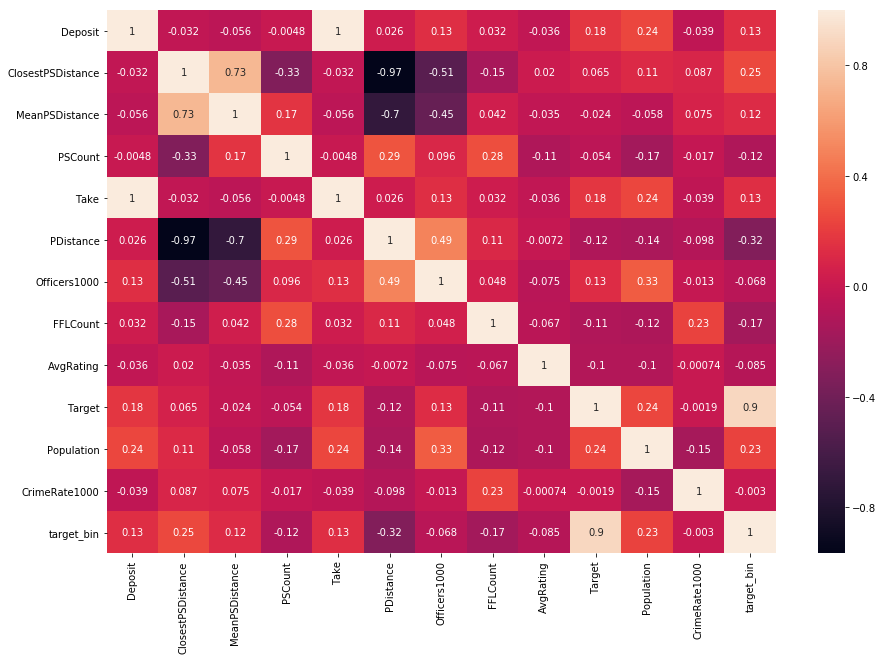

In [65]:
plt.figure(figsize = (15,10))
sns.heatmap(data2.corr(), annot=True)

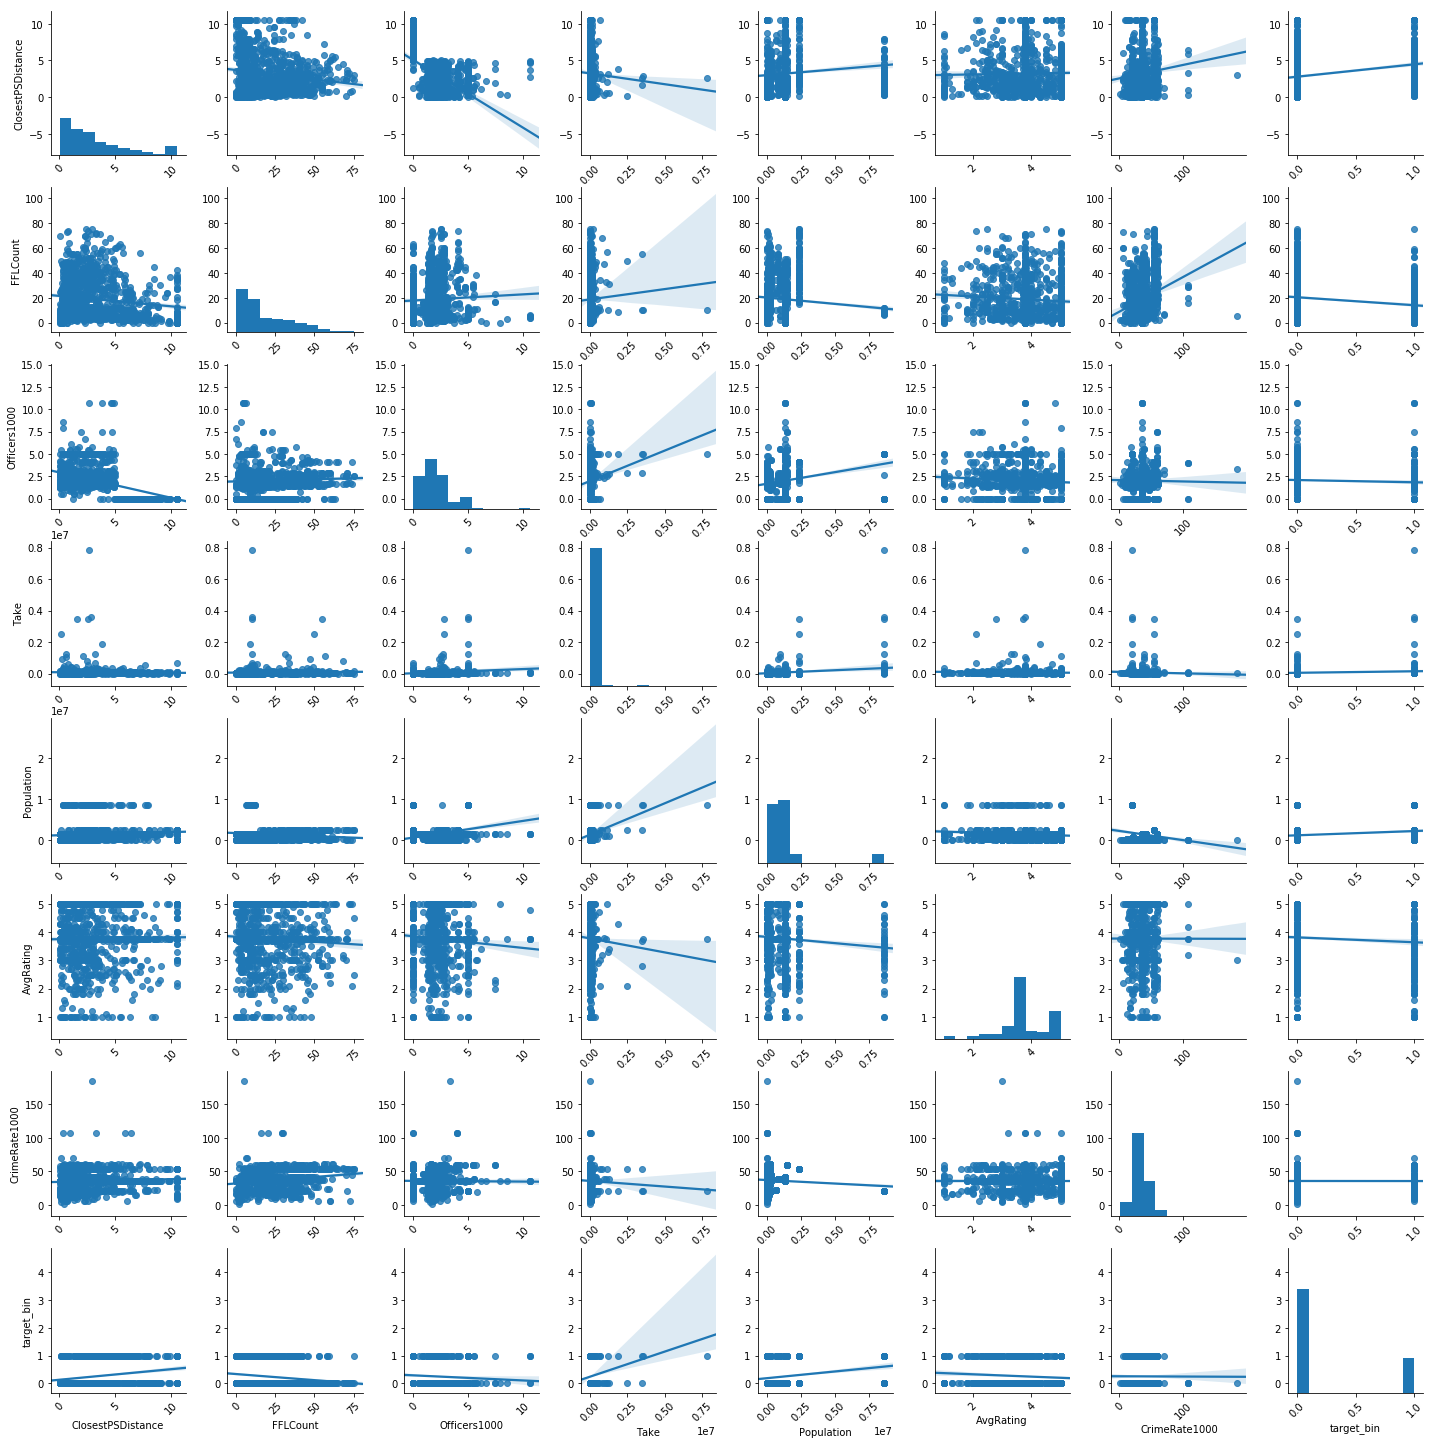

In [66]:
#Distance, P(Caught by Distance), Target correlation
g = sns.pairplot(data2[['ClosestPSDistance',  'FFLCount', 'Officers1000', 'Take', 'Population', 'AvgRating', 'CrimeRate1000', 'target_bin']], diag_kind="hist", kind="reg")
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45)

## RandomForest with GridSearch for best Features, Max Depth and Min Leaf

In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [68]:
feature_cols = ['ClosestPSDistance',
       'MeanPSDistance', 'PSCount', 'Take', 'PDistance', 'Officers1000',
       'FFLCount', 'AvgRating', 'Population', 'CrimeRate1000']
X = data2[feature_cols]
y = data2['target_bin']

0.958453297735
{'max_depth': 8}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)


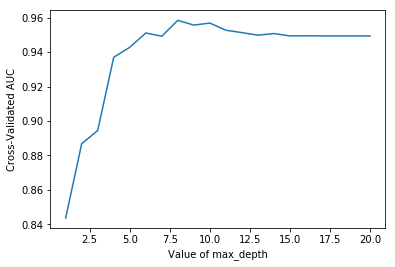

In [69]:
#Use RandomForest
rf = RandomForestClassifier(random_state=1)
max_depth_range = range(1, 21)
param_grid = dict(max_depth=list(max_depth_range))
grid = GridSearchCV(rf, param_grid, cv=10, scoring='roc_auc')
grid.fit(X, y)

grid_mean_scores = grid.cv_results_['mean_test_score']

# plot the results
plt.plot(max_depth_range, grid_mean_scores)
plt.xlabel('Value of max_depth')
plt.ylabel('Cross-Validated AUC')
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

In [70]:
pd.DataFrame({'feature':feature_cols, 'importance':grid.best_estimator_.feature_importances_}).sort_values(by=['importance'])

,feature,importance
2,PSCount,0.019262
7,AvgRating,0.025676
1,MeanPSDistance,0.046475
8,Population,0.053332
5,Officers1000,0.057614
9,CrimeRate1000,0.057788
6,FFLCount,0.107753
4,PDistance,0.134155
0,ClosestPSDistance,0.137526
3,Take,0.360418


### Remove Features

0.958712429183


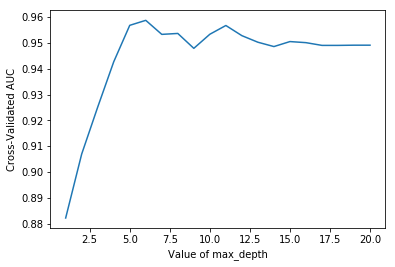

In [71]:
# Remove features: MeanPSDistance, PSCount
# Use the rest
feature_cols = ['ClosestPSDistance', 'Take', 'PDistance', 'Officers1000',
       'FFLCount', 'AvgRating', 'Population', 'CrimeRate1000']
X = data2[feature_cols]
y = data2['target_bin']

rf = RandomForestClassifier(random_state=1)
max_depth_range = range(1, 21)
param_grid = dict(max_depth=list(max_depth_range))
grid = GridSearchCV(rf, param_grid, cv=10, scoring='roc_auc')
grid.fit(X, y)

grid_mean_scores = grid.cv_results_['mean_test_score']

# plot the results
plt.plot(max_depth_range, grid_mean_scores)
plt.xlabel('Value of max_depth')
plt.ylabel('Cross-Validated AUC')
print (grid.best_score_)


### Best Depth and Min Leaf

In [72]:
# Use Grid Search Cross Validation for best depth AND min leaf
max_depth_range = range(1, 21)
leaf_range = range(1, 11)
param_grid = dict(max_depth=list(max_depth_range), min_samples_leaf=list(leaf_range))
grid = GridSearchCV(rf, param_grid, cv=10, scoring='roc_auc')
grid.fit(X, y)
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.969067668818
{'max_depth': 8, 'min_samples_leaf': 2}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)


## Use the max_depth and min_samples_leaf for the model

In [73]:
rf2 = RandomForestClassifier(random_state=1, max_depth=8, min_samples_leaf=2)
rf2.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [75]:
#Check the model with prediction
y_pred = rf2.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.97923875432525953

In [76]:
from sklearn.tree import export_graphviz
idx = 0
for tree in rf2.estimators_:
    export_graphviz(tree, out_file='tree_banks_' + str(idx) + '.dot', feature_names=feature_cols)
    idx = idx + 1

In [77]:
! dot -Tpng tree_banks_1.dot -o tree_banks_1.png

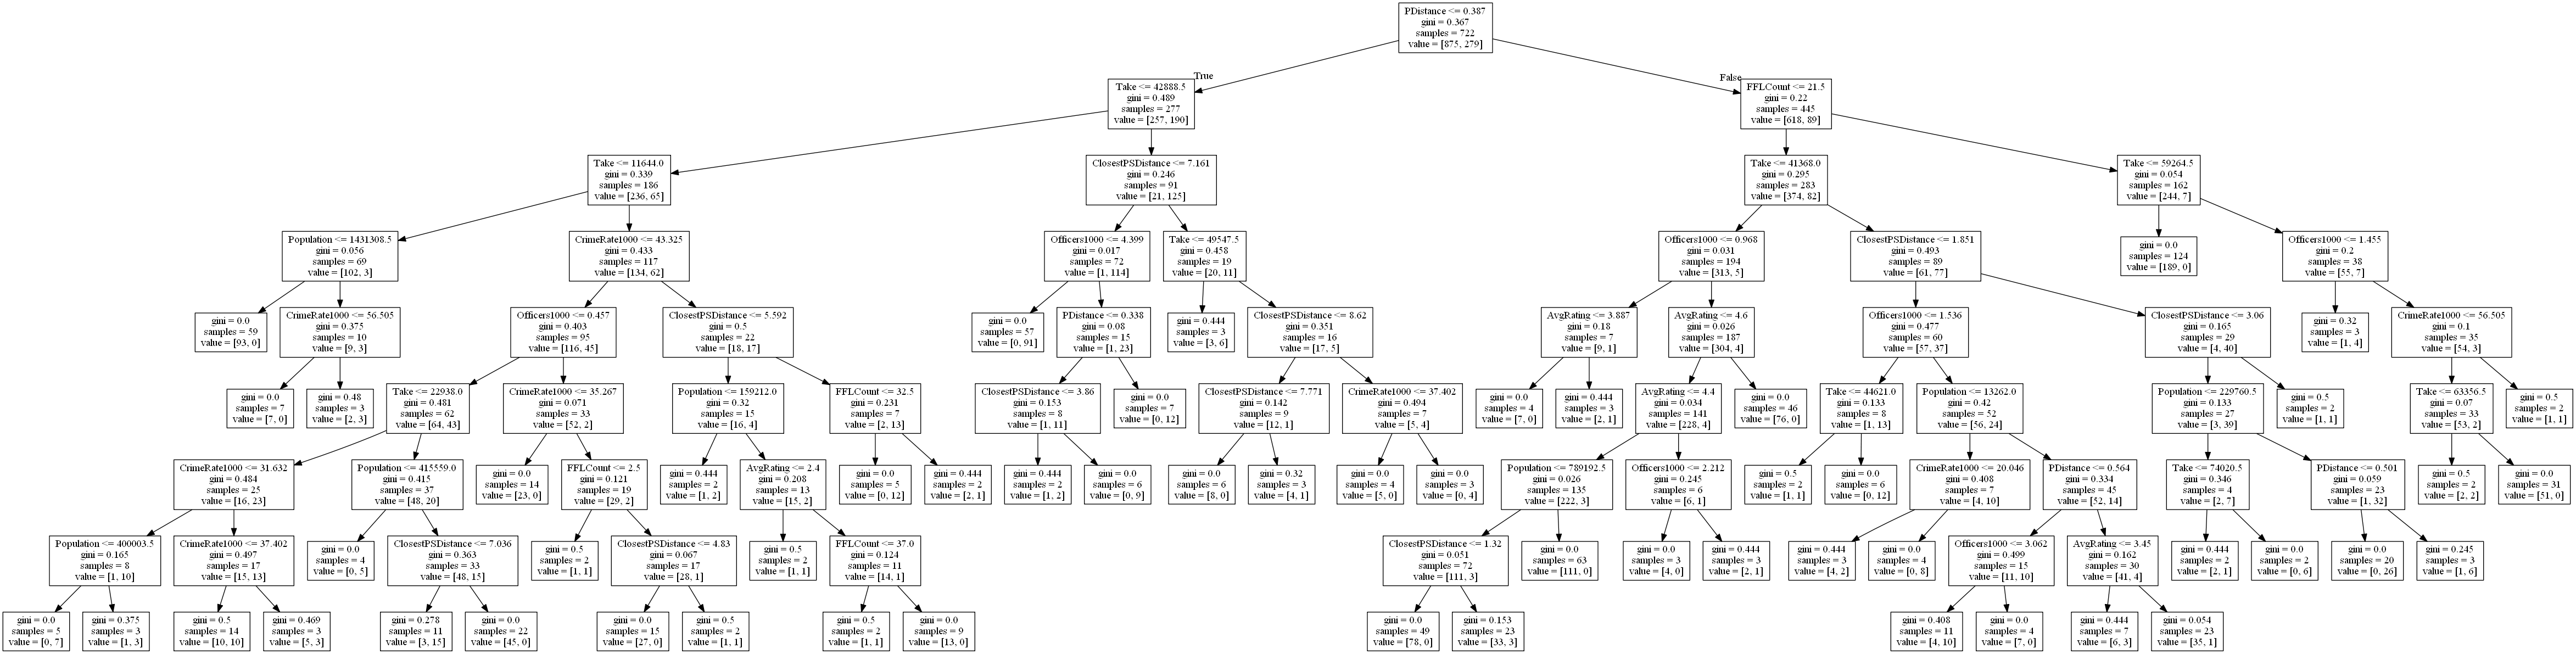

In [78]:
from IPython.display import Image
from IPython.display import display

display(Image('tree_banks_1.png'))

## Save Model to Pickle

In [79]:
try:
    import cPickle as pickle
except ImportError:
    import pickle

In [80]:
## Save the RandomForestClassifier model
out_s = open('targetbanks_randomforestclassifier.pkl', 'wb')
pickle.dump(rf2, out_s)
out_s.close()